,t,ax,ay,az,gx,gy,gz,p_x,p_y,p_z,x,y,z,vx,vy,vz,mx,my,mz
0,0.00,0.107371,0.214673,-9.785818,0.001543,-0.000963,0.000334,20.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.057626,0.171145,-9.747162,0.000072,-0.000433,0.104093,19.999989,0.020944,0.004189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.063752,0.236506,-9.776790,-0.000760,0.000321,0.104297,19.999956,0.041888,0.008378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.03,0.073474,0.193505,-9.806137,-0.000422,-0.000963,0.106575,19.999901,0.062832,0.012566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.04,0.096407,0.218220,-9.793394,-0.000012,-0.000171,0.106493,19.999825,0.083776,0.016755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.05,0.074347,0.219734,-9.769423,-0.000348,-0.000142,0.107056,19.999726,0.104719,0.020944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.06,0.077622,0.159982,-9.781096,0.000655,0.000974,0.104999,19.999605,0.125663,0.025132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.07,0.077727,0.219175,-9.790787,-0.000030,-0.000897,0.104054,19.999463,0.146606,0.029320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.08,0.068931,0.183826,-9.780016,0.000702,0.001380,0.105692,19.999298,0.167550,0.033509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.09,0.071939,0.205971,-9.777531,-0.000871,0.000636,0.106270,19.999112,0.188493,0.037697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_26813/1604096076.py:234: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')


Simulazione completata. File CSV salvati per ogni sensore.


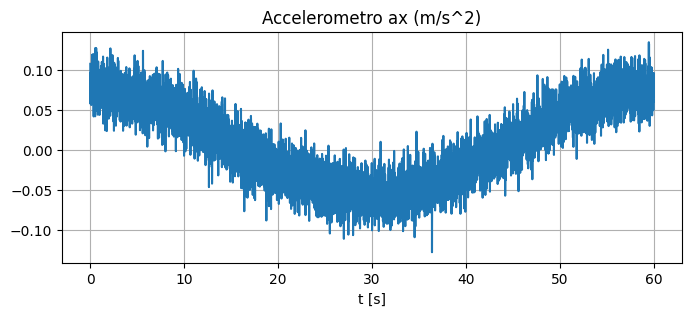

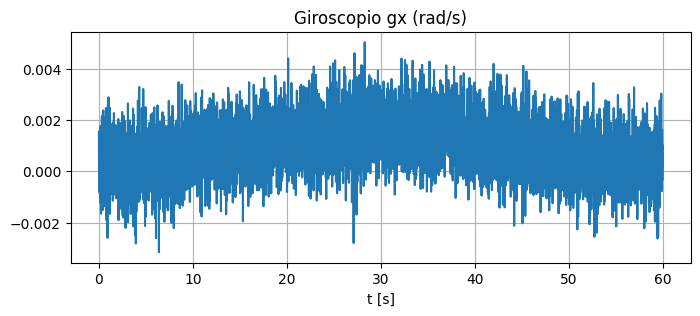

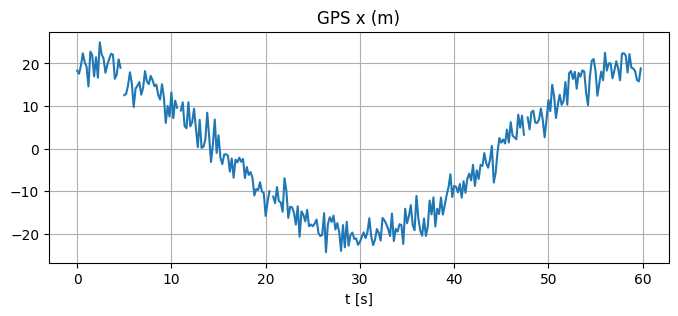

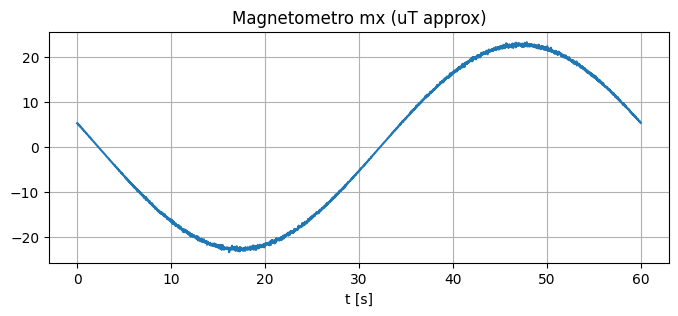

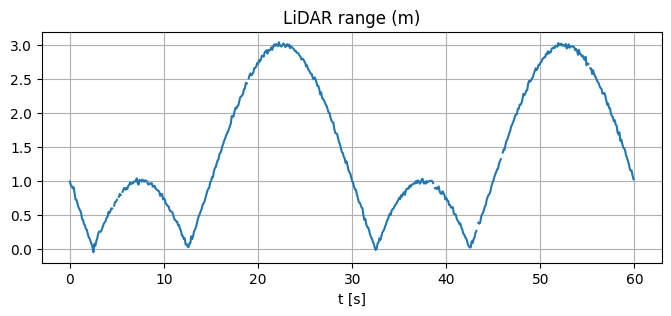

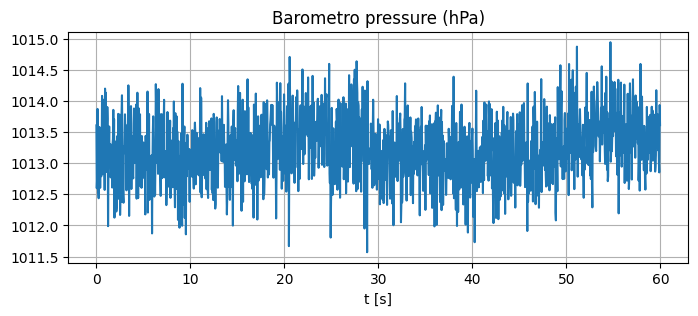

In [5]:
# Simulatore sensori: IMU (acc+gyro), GPS, Magnetometro, LiDAR (range), Barometro
# Esegue una simulazione di esempio e produce grafici + salvataggio dei dati.
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime

np.random.seed(42)

def rotz(yaw):
    c = np.cos(yaw); s = np.sin(yaw)
    return np.array([[c, -s, 0],[s, c, 0],[0,0,1]])

def roty(p):
    c = np.cos(p); s = np.sin(p)
    return np.array([[c,0,s],[0,1,0],[-s,0,c]])

def rotx(r):
    c = np.cos(r); s = np.sin(r)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]])

def euler_to_rot(roll, pitch, yaw):
    return rotz(yaw) @ roty(pitch) @ rotx(roll)

# Traiettoria di ground-truth (posizione 3D e orientamento yaw)
def ground_truth_trajectory(t):
    # posizione: movimento circolare orizzontale + onda verticale
    R = 20.0  # raggio in metri
    omega = 2*math.pi/60.0  # periodo 60s
    x = R*np.cos(omega*t)
    y = R*np.sin(omega*t)
    z = 2.0 * np.sin(2*omega*t)  # oscillazione verticale piccola
    # velocità e accelerazione analitiche
    vx = -R*omega*np.sin(omega*t)
    vy =  R*omega*np.cos(omega*t)
    vz = 2.0*2*omega*np.cos(2*omega*t) * 0.5  # derivative simplified
    ax = -R*(omega**2)*np.cos(omega*t)
    ay = -R*(omega**2)*np.sin(omega*t)
    az = -2.0*(2*omega)**2 * np.sin(2*omega*t) * 0.25  # approximate
    # yaw seguente la tangente alla traiettoria (heading)
    yaw = math.atan2(vy, vx) if (abs(vx)+abs(vy))>1e-6 else 0.0
    # small roll/pitch from lateral acceleration (simple bicycle-like tilt)
    g = 9.80665
    roll = math.atan2(ay, g) * 0.3  # scaled to be small
    pitch = math.atan2(-ax, g) * 0.3
    return np.array([x,y,z]), np.array([vx,vy,vz]), np.array([ax,ay,az]), np.array([roll,pitch,yaw])

class SensorSimulator:
    def __init__(self, duration_s=60.0, imu_rate=100.0, gps_rate=5.0, mag_rate=50.0, lidar_rate=10.0, baro_rate=25.0):
        self.dt = 1.0/imu_rate
        self.imu_rate = imu_rate
        self.gps_rate = gps_rate
        self.mag_rate = mag_rate
        self.lidar_rate = lidar_rate
        self.baro_rate = baro_rate
        self.t = np.arange(0, duration_s, self.dt)
        self.g = np.array([0,0,9.80665])  # gravità (NED convention positive down)
        self._generate_truth()
    
    def _generate_truth(self):
        N = len(self.t)
        P = np.zeros((N,3))
        V = np.zeros((N,3))
        A = np.zeros((N,3))
        E = np.zeros((N,3))
        for i,ti in enumerate(self.t):
            p,v,a,e = ground_truth_trajectory(ti)
            P[i] = p
            V[i] = v
            A[i] = a
            E[i] = e
        self.P = P
        self.V = V
        self.A = A
        self.E = E  # roll,pitch,yaw
    
    def simulate_imu(self, accel_bias=[0.01, -0.02, 0.03], gyro_bias=[0.001, -0.0005, 0.0008],
                     accel_noise_std=0.02, gyro_noise_std=0.001, accel_bias_rw_std=1e-6, gyro_bias_rw_std=1e-7):
        N = len(self.t)
        acc_meas = np.zeros((N,3))
        gyr_meas = np.zeros((N,3))
        ba = np.array(accel_bias, dtype=float)
        bg = np.array(gyro_bias, dtype=float)
        for i in range(N):
            roll,pitch,yaw = self.E[i]
            R = euler_to_rot(roll,pitch,yaw)
            # specific force in body frame: R^T * (a_world - g_world)
            a_world = self.A[i]
            specific_force = R.T @ (a_world - self.g)
            # add bias random walk and white noise
            ba += np.random.normal(scale=accel_bias_rw_std, size=3)
            bg += np.random.normal(scale=gyro_bias_rw_std, size=3)
            acc_meas[i] = specific_force + ba + np.random.normal(scale=accel_noise_std, size=3)
            # gyro: approximate angular rates from Euler derivative (finite diff)
            if i==0:
                rates = np.array([0.,0.,0.])
            else:
                de = (self.E[i] - self.E[i-1]) / self.dt
                # small-angle approx: body rates ≈ euler rates mapped
                roll_dot,pitch_dot,yaw_dot = de
                # transform to body rates (approximate)
                rates = np.array([roll_dot, pitch_dot, yaw_dot*np.cos(pitch)])
            gyr_meas[i] = rates + bg + np.random.normal(scale=gyro_noise_std, size=3)
        imu = pd.DataFrame({
            't': self.t,
            'ax': acc_meas[:,0],'ay': acc_meas[:,1],'az': acc_meas[:,2],
            'gx': gyr_meas[:,0],'gy': gyr_meas[:,1],'gz': gyr_meas[:,2],
            'p_x': self.P[:,0],'p_y': self.P[:,1],'p_z': self.P[:,2]
        })
        self.imu = imu
        return imu
    
    def simulate_gps(self, pos_noise_std=2.5, vel_noise_std=0.1, outage_prob=0.01):
        # sample at gps_rate
        step = int(round(1.0/(self.dt*self.gps_rate)))
        if step < 1: step = 1
        idx = np.arange(0, len(self.t), step)
        times = self.t[idx]
        pos = self.P[idx] + np.random.normal(scale=pos_noise_std, size=(len(idx),3))
        vel = self.V[idx] + np.random.normal(scale=vel_noise_std, size=(len(idx),3))
        # occasional outage/drop samples
        mask = np.random.rand(len(idx)) > outage_prob
        pos[~mask] = np.nan
        vel[~mask] = np.nan
        gps = pd.DataFrame({
            't': times,
            'x': pos[:,0],'y': pos[:,1],'z': pos[:,2],
            'vx': vel[:,0],'vy': vel[:,1],'vz': vel[:,2]
        })
        self.gps = gps
        return gps
    
    def simulate_mag(self, mag_field_ned = np.array([22.0, 5.0, -42.0]), noise_std=0.01, scale_error=0.01):
        # Earth's magnetic field in microtesla (approx). We'll rotate by attitude and add noise
        step = int(round(1.0/(self.dt*self.mag_rate)))
        if step < 1: step = 1
        idx = np.arange(0, len(self.t), step)
        times = self.t[idx]
        mags = np.zeros((len(idx),3))
        for i,j in enumerate(idx):
            roll,pitch,yaw = self.E[j]
            R = euler_to_rot(roll,pitch,yaw)
            # magnetic field in body frame:
            b_body = R.T @ mag_field_ned
            # apply small scale factor and noise
            sf = 1.0 + np.random.normal(scale=scale_error, size=3)
            mags[i] = b_body * sf + np.random.normal(scale=noise_std, size=3)
        mag = pd.DataFrame({'t': times, 'mx': mags[:,0], 'my': mags[:,1], 'mz': mags[:,2]})
        self.mag = mag
        return mag
    
    def simulate_lidar(self, sensor_height=1.0, noise_std=0.02, max_range=40.0, dropout_prob=0.01):
        # LiDAR pointing down gives altitude above ground; we'll assume ground z=0
        step = int(round(1.0/(self.dt*self.lidar_rate)))
        if step < 1: step = 1
        idx = np.arange(0, len(self.t), step)
        times = self.t[idx]
        z_true = self.P[idx,2]  # altitude
        ranges = sensor_height - z_true  # if sensor is at vehicle frame height above ground
        ranges = np.abs(ranges)  # positive range
        ranges += np.random.normal(scale=noise_std, size=len(ranges))
        ranges[ranges>max_range] = np.nan
        # dropout
        mask = np.random.rand(len(ranges)) > dropout_prob
        ranges[~mask] = np.nan
        lidar = pd.DataFrame({'t': times, 'range': ranges, 'z_true': z_true})
        self.lidar = lidar
        return lidar
    
    def simulate_baro(self, sea_level_pressure=1013.25, noise_std=0.5, drift_std=0.01):
        # simple barometer: convert altitude to pressure via barometric formula (isothermal approx)
        step = int(round(1.0/(self.dt*self.baro_rate)))
        if step < 1: step = 1
        idx = np.arange(0, len(self.t), step)
        times = self.t[idx]
        z = self.P[idx,2]
        # altitude to pressure (approx): p = p0 * exp(-z/H), H~8.5km
        H = 8500.0
        pressures = sea_level_pressure * np.exp(-z / H)
        pressures += np.random.normal(scale=noise_std, size=len(pressures))
        # slowly varying drift (bias)
        drift = np.cumsum(np.random.normal(scale=drift_std, size=len(pressures)))
        pressures += drift
        baro = pd.DataFrame({'t': times, 'pressure_hPa': pressures, 'z_true': z})
        self.baro = baro
        return baro

# Esempio uso: simuliamo 60s
sim = SensorSimulator(duration_s=60.0, imu_rate=100.0, gps_rate=5.0, mag_rate=50.0, lidar_rate=10.0, baro_rate=25.0)
imu = sim.simulate_imu()
gps = sim.simulate_gps()
mag = sim.simulate_mag()
lidar = sim.simulate_lidar()
baro = sim.simulate_baro()

# Mostriamo alcuni grafici: ogni sensore in una figura separata (regola matplotlib)
plt.figure(figsize=(8,3))
plt.plot(imu['t'], imu['ax'])
plt.title('Accelerometro ax (m/s^2)')
plt.xlabel('t [s]')
plt.grid(True)
plt.figure(figsize=(8,3))
plt.plot(imu['t'], imu['gx'])
plt.title('Giroscopio gx (rad/s)')
plt.xlabel('t [s]')
plt.grid(True)
plt.figure(figsize=(8,3))
plt.plot(gps['t'], gps['x'])
plt.title('GPS x (m)')
plt.xlabel('t [s]')
plt.grid(True)
plt.figure(figsize=(8,3))
plt.plot(mag['t'], mag['mx'])
plt.title('Magnetometro mx (uT approx)')
plt.xlabel('t [s]')
plt.grid(True)
plt.figure(figsize=(8,3))
plt.plot(lidar['t'], lidar['range'])
plt.title('LiDAR range (m)')
plt.xlabel('t [s]')
plt.grid(True)
plt.figure(figsize=(8,3))
plt.plot(baro['t'], baro['pressure_hPa'])
plt.title('Barometro pressure (hPa)')
plt.xlabel('t [s]')
plt.grid(True)

# Salviamo i primi campioni in tabella di esempio
df_preview = pd.concat([imu.head(10), gps.head(10), mag.head(10)], axis=0, ignore_index=True, sort=False)
display(df_preview.head(15))

# Salvataggio dati su file CSV (opzionale)
now = datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')
imu.to_csv(f'sim_imu_{now}.csv', index=False)
gps.to_csv(f'sim_gps_{now}.csv', index=False)
mag.to_csv(f'sim_mag_{now}.csv', index=False)
lidar.to_csv(f'sim_lidar_{now}.csv', index=False)
baro.to_csv(f'sim_baro_{now}.csv', index=False)

print("Simulazione completata. File CSV salvati per ogni sensore.")

